In [12]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import random

In [13]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.12.1+cu113  Device: cuda


### Data Load

In [14]:
class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')

            if (i+1) < 2000:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images

In [15]:
def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128, 
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
        # train mode일 경우 Data Augumentation을 위해 RamdomHorizontalFip
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)
    # 각 이미지마다 CenterCrop, Resize, Normalize
    # 대부분의 이미지 DataLoader에 쓰이는 일반적인 조합

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
        # CelebA는 구조가 복잡하므로, 앞에서 별도로 Class를 선언하여 전처리함
        
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)
        # RaFD는 특별히 복잡한 구성을 가진 데이터셋이 아니므로,
        # PyTorch 내장 ImageFolder 함수로도 충분

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

### Model

In [16]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))
            # Conv2d + InstaceNorm2d 2개 사이에 ReLU Activation Fuction이 끼어있는 구조

    def forward(self, x):
        return x + self.main(x)
        # ResidualBlock: input과 output을 더해줌

In [17]:
class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)
        
        # condition이 이미지 사이즈에 맞춰 확대되고 conatenate되는 방식으로 학습이 이루어짐

In [18]:
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

### Logger

In [19]:
import tensorflow as tf

class Logger(object):
    """Tensorboard logger."""

    def __init__(self, log_dir):
        """Initialize summary writer."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Add scalar summary."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

### Solver

In [20]:
class Solver(object):
    """Solver for training and testing StarGAN."""

    def __init__(self, config):
        """Initialize configurations."""

        # Data loader.
        self.celeba_loader = celeba_loader
        self.rafd_loader = rafd_loader

        # Model configurations.
        self.c_dim = config.c_dim
        self.c2_dim = config.c2_dim
        self.image_size = config.image_size
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.g_repeat_num = config.g_repeat_num
        self.d_repeat_num = config.d_repeat_num
        self.lambda_cls = config.lambda_cls
        self.lambda_rec = config.lambda_rec
        self.lambda_gp = config.lambda_gp

        # Training configurations.
        self.dataset = config.dataset
        self.batch_size = config.batch_size
        self.num_iters = config.num_iters
        self.num_iters_decay = config.num_iters_decay
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.n_critic = config.n_critic
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.resume_iters = config.resume_iters
        self.selected_attrs = config.selected_attrs

        # Test configurations.
        self.test_iters = config.test_iters

        # Miscellaneous.
        self.use_tensorboard = config.use_tensorboard
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Directories.
        self.log_dir = config.log_dir
        self.sample_dir = config.sample_dir
        self.model_save_dir = config.model_save_dir
        self.result_dir = config.result_dir

        # Step size.
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.model_save_step = config.model_save_step
        self.lr_update_step = config.lr_update_step

        # Build the model and tensorboard.
        self.build_model()
        if self.use_tensorboard:
            self.build_tensorboard()

    def build_model(self):
        """Create a generator and a discriminator."""
        if self.dataset in ['CelebA', 'RaFD']:
            self.G = Generator(self.g_conv_dim, self.c_dim, self.g_repeat_num)
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim, self.d_repeat_num) 
        elif self.dataset in ['Both']:
            self.G = Generator(self.g_conv_dim, self.c_dim+self.c2_dim+2, self.g_repeat_num)   # 2 for mask vector.
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim+self.c2_dim, self.d_repeat_num)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])
        self.print_network(self.G, 'G')
        self.print_network(self.D, 'D')
            
        self.G.to(self.device)
        self.D.to(self.device)

    def print_network(self, model, name):
        """Print out the network information."""
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print("The number of parameters: {}".format(num_params))

    def restore_model(self, resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    def build_tensorboard(self):
        """Build a tensorboard logger."""
        from logger import Logger
        self.logger = Logger(self.log_dir)

    def update_lr(self, g_lr, d_lr):
        """Decay learning rates of the generator and discriminator."""
        for param_group in self.g_optimizer.param_groups:
            param_group['lr'] = g_lr
        for param_group in self.d_optimizer.param_groups:
            param_group['lr'] = d_lr

    def reset_grad(self):
        """Reset the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def denorm(self, x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

    def gradient_penalty(self, y, x):
        """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
        weight = torch.ones(y.size()).to(self.device)
        dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]

        dydx = dydx.view(dydx.size(0), -1)
        dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
        return torch.mean((dydx_l2norm-1)**2)

    def label2onehot(self, labels, dim):
        """Convert label indices to one-hot vectors."""
        batch_size = labels.size(0)
        out = torch.zeros(batch_size, dim)
        out[np.arange(batch_size), labels.long()] = 1
        return out

    def create_labels(self, c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get hair color indices.
        if dataset == 'CelebA':
            hair_color_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                    hair_color_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'CelebA':
                c_trg = c_org.clone()
                if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in hair_color_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.
            elif dataset == 'RaFD':
                c_trg = self.label2onehot(torch.ones(c_org.size(0))*i, c_dim)

            c_trg_list.append(c_trg.to(self.device))
        return c_trg_list

    def classification_loss(self, logit, target, dataset='CelebA'):
        """Compute binary or softmax cross entropy loss."""
        if dataset == 'CelebA':
            return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
        elif dataset == 'RaFD':
            return F.cross_entropy(logit, target)

    def train(self):
        """Train StarGAN within a single dataset."""
        # Set data loader.
        if self.dataset == 'CelebA':
            data_loader = self.celeba_loader
        elif self.dataset == 'RaFD':
            data_loader = self.rafd_loader

        # Fetch fixed inputs for debugging.
        data_iter = iter(data_loader)
        x_fixed, c_org = next(data_iter)
        x_fixed = x_fixed.to(self.device)
        c_fixed_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)

        # Learning rate cache for decaying.
        g_lr = self.g_lr
        d_lr = self.d_lr

        # Start training from scratch or resume training.
        start_iters = 0
        if self.resume_iters:
            start_iters = self.resume_iters
            self.restore_model(self.resume_iters)

        # Start training.
        print('Start training...')
        start_time = time.time()
        for i in range(start_iters, self.num_iters):

            # =================================================================================== #
            #                             1. Preprocess input data                                #
            # =================================================================================== #
            
            '''
            generator의 input으로 target domain과 input image를 channel-wise concatination을 통해 만든 input을 사용한다.
            channel-wise로 concatination하기 위해서는 domain의 height, width를 image의 height, width와 맞춰야 하기 때문에
            각 label과 mask vector의 size를 128*128로 확장한다.
            생성된 target domain을 input image와 chnnel-wise로 concatination해서 input으로 사용한다.
            '''
            
            # Fetch real images and labels.
            try:
                x_real, label_org = next(data_iter)
            except:
                data_iter = iter(data_loader)
                x_real, label_org = next(data_iter)

            # Generate target domain labels randomly.
            rand_idx = torch.randperm(label_org.size(0))
            label_trg = label_org[rand_idx]

            if self.dataset == 'CelebA':
                c_org = label_org.clone()
                c_trg = label_trg.clone()
            elif self.dataset == 'RaFD':
                c_org = self.label2onehot(label_org, self.c_dim)
                c_trg = self.label2onehot(label_trg, self.c_dim)

            x_real = x_real.to(self.device)           # Input images.
            c_org = c_org.to(self.device)             # Original domain labels.
            c_trg = c_trg.to(self.device)             # Target domain labels.
            label_org = label_org.to(self.device)     # Labels for computing classification loss.
            label_trg = label_trg.to(self.device)     # Labels for computing classification loss.

            # =================================================================================== #
            #                             2. Train the discriminator                              #
            # =================================================================================== #

            # Compute loss with real images.
            '''
            real/fake에 대한 예측과, domain에 대한 예측을 이용해 loss를 계산
            '''
            out_src, out_cls = self.D(x_real)
            d_loss_real = - torch.mean(out_src)
            d_loss_cls = self.classification_loss(out_cls, label_org, self.dataset)

            # Compute loss with fake images.
            '''
            real/fake 부분만을 이용해서 loss를 계산
            '''
            x_fake = self.G(x_real, c_trg)
            out_src, out_cls = self.D(x_fake.detach())
            d_loss_fake = torch.mean(out_src)

            # Compute loss for gradient penalty.
            '''
            wasserstein gan loss를 사용하기 위해 존재하는데, 
            이 부분을 real과 fake data 사이의 어떤 부분에서도 gradient norm이 1에 가깝게 하는 것을 목표
            '''
            alpha = torch.rand(x_real.size(0), 1, 1, 1).to(self.device)
            x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            out_src, _ = self.D(x_hat)
            d_loss_gp = self.gradient_penalty(out_src, x_hat)

            # Backward and optimize.
            '''
            구해진 loss를 더하고 backward and optimize를 진행
            '''
            d_loss = d_loss_real + d_loss_fake + self.lambda_cls * d_loss_cls + self.lambda_gp * d_loss_gp
            self.reset_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Logging.
            loss = {}
            loss['D/loss_real'] = d_loss_real.item()
            loss['D/loss_fake'] = d_loss_fake.item()
            loss['D/loss_cls'] = d_loss_cls.item()
            loss['D/loss_gp'] = d_loss_gp.item()
            
            # =================================================================================== #
            #                               3. Train the generator                                #
            # =================================================================================== #
            
            if (i+1) % self.n_critic == 0:
                
                # Original-to-target domain.
                '''
                생성된 fake image를 discriminator의 forward 과정을 통해 얻은 값을 이용해 loss를 계산하는 부분이다. 
                real/fake인지에 대한 fake_loss, domain인 정확하게 분류했는지에 대한 cls_loss
                '''
                x_fake = self.G(x_real, c_trg)
                out_src, out_cls = self.D(x_fake)
                g_loss_fake = - torch.mean(out_src)
                g_loss_cls = self.classification_loss(out_cls, label_trg, self.dataset)

                # Target-to-original domain.
                '''
                reconstruction loss를 구하는 부분이다.
                이 부분은 fake image를 기존의 input image로 재생성하는 부분이다. 
                input image와 reconstructed image가 최대한 같게 만들어주는 것이 목표다. 
                이 loss를 사용하는 것은 content는 보존하고, style만 바뀌길 원해서이다. 
                fake image를 이용해서 input image를 다시 재생성하지 못한다면, 
                이는 content가 소실된 것을 의미하고, content를 구별할 수 없을 정도로 변했을 수도 있다.
                '''
                x_reconst = self.G(x_fake, c_org)
                g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

                # Backward and optimize.
                '''
                계산한 모든 로스를 더하는 부분이다. 이때 lambda라는 변수를 이용해 가중치를 부여할 수 있다. 
                예를 들어 reconstrion_loss에 lambda 값으로 10을 곱했다면, 
                network가 reconstruction 부분에 대해 더 좋은 결과를 얻으려고 해, 
                변환 결과인 fake image에서 content 정보가 보다 잘 보존돼있을 것이다. 
                물론 한 부분을 강화함으로써 다른 부분에서 취약해질 수 있다.
                '''
                g_loss = g_loss_fake + self.lambda_rec * g_loss_rec + self.lambda_cls * g_loss_cls
                self.reset_grad()
                g_loss.backward()
                self.g_optimizer.step()

                # Logging.
                loss['G/loss_fake'] = g_loss_fake.item()
                loss['G/loss_rec'] = g_loss_rec.item()
                loss['G/loss_cls'] = g_loss_cls.item()

            # =================================================================================== #
            #                                 4. Miscellaneous                                    #
            # =================================================================================== #

            # Print out training information.
            if (i+1) % self.log_step == 0:
                et = time.time() - start_time
                et = str(datetime.timedelta(seconds=et))[:-7]
                log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, self.num_iters)
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)

                if self.use_tensorboard:
                    for tag, value in loss.items():
                        self.logger.scalar_summary(tag, value, i+1)

            # Translate fixed images for debugging.
            if (i+1) % self.sample_step == 0:
                with torch.no_grad():
                    x_fake_list = [x_fixed]
                    for c_fixed in c_fixed_list:
                        x_fake_list.append(self.G(x_fixed, c_fixed))
                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
                    print('Saved real and fake images into {}...'.format(sample_path))

            # Save model checkpoints.
            if (i+1) % self.model_save_step == 0:
                G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(i+1))
                D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(i+1))
                torch.save(self.G.state_dict(), G_path)
                torch.save(self.D.state_dict(), D_path)
                print('Saved model checkpoints into {}...'.format(self.model_save_dir))

            # Decay learning rates.
            if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
                g_lr -= (self.g_lr / float(self.num_iters_decay))
                d_lr -= (self.d_lr / float(self.num_iters_decay))
                self.update_lr(g_lr, d_lr)
                print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

    def train_multi(self):
        """Train StarGAN with multiple datasets."""        
        # Data iterators.
        celeba_iter = iter(self.celeba_loader)
        rafd_iter = iter(self.rafd_loader)

        # Fetch fixed inputs for debugging.
        x_fixed, c_org = next(celeba_iter)
        x_fixed = x_fixed.to(self.device)
        c_celeba_list = self.create_labels(c_org, self.c_dim, 'CelebA', self.selected_attrs)
        c_rafd_list = self.create_labels(c_org, self.c2_dim, 'RaFD')
        zero_celeba = torch.zeros(x_fixed.size(0), self.c_dim).to(self.device)           # Zero vector for CelebA.
        zero_rafd = torch.zeros(x_fixed.size(0), self.c2_dim).to(self.device)             # Zero vector for RaFD.
        mask_celeba = self.label2onehot(torch.zeros(x_fixed.size(0)), 2).to(self.device)  # Mask vector: [1, 0].
        mask_rafd = self.label2onehot(torch.ones(x_fixed.size(0)), 2).to(self.device)     # Mask vector: [0, 1].

        # Learning rate cache for decaying.
        g_lr = self.g_lr
        d_lr = self.d_lr

        # Start training from scratch or resume training.
        start_iters = 0
        if self.resume_iters:
            start_iters = self.resume_iters
            self.restore_model(self.resume_iters)

        # Start training.
        print('Start training...')
        start_time = time.time()
        for i in range(start_iters, self.num_iters):
            for dataset in ['CelebA', 'RaFD']:

                # =================================================================================== #
                #                             1. Preprocess input data                                #
                # =================================================================================== #
                
                # Fetch real images and labels.
                data_iter = celeba_iter if dataset == 'CelebA' else rafd_iter
                
                try:
                    x_real, label_org = next(data_iter)
                except:
                    if dataset == 'CelebA':
                        celeba_iter = iter(self.celeba_loader)
                        x_real, label_org = next(celeba_iter)
                    elif dataset == 'RaFD':
                        rafd_iter = iter(self.rafd_loader)
                        x_real, label_org = next(rafd_iter)

                # Generate target domain labels randomly.
                rand_idx = torch.randperm(label_org.size(0))
                label_trg = label_org[rand_idx]

                if dataset == 'CelebA':
                    c_org = label_org.clone()
                    c_trg = label_trg.clone()
                    zero = torch.zeros(x_real.size(0), self.c2_dim)
                    mask = self.label2onehot(torch.zeros(x_real.size(0)), 2)
                    c_org = torch.cat([c_org, zero, mask], dim=1)
                    c_trg = torch.cat([c_trg, zero, mask], dim=1)
                elif dataset == 'RaFD':
                    c_org = self.label2onehot(label_org, self.c2_dim)
                    c_trg = self.label2onehot(label_trg, self.c2_dim)
                    zero = torch.zeros(x_real.size(0), self.c_dim)
                    mask = self.label2onehot(torch.ones(x_real.size(0)), 2)
                    c_org = torch.cat([zero, c_org, mask], dim=1)
                    c_trg = torch.cat([zero, c_trg, mask], dim=1)

                x_real = x_real.to(self.device)             # Input images.
                c_org = c_org.to(self.device)               # Original domain labels.
                c_trg = c_trg.to(self.device)               # Target domain labels.
                label_org = label_org.to(self.device)       # Labels for computing classification loss.
                label_trg = label_trg.to(self.device)       # Labels for computing classification loss.

                # =================================================================================== #
                #                             2. Train the discriminator                              #
                # =================================================================================== #

                # Compute loss with real images.
                out_src, out_cls = self.D(x_real)
                out_cls = out_cls[:, :self.c_dim] if dataset == 'CelebA' else out_cls[:, self.c_dim:]
                d_loss_real = - torch.mean(out_src)
                d_loss_cls = self.classification_loss(out_cls, label_org, dataset)

                # Compute loss with fake images.
                x_fake = self.G(x_real, c_trg)
                out_src, _ = self.D(x_fake.detach())
                d_loss_fake = torch.mean(out_src)

                # Compute loss for gradient penalty.
                alpha = torch.rand(x_real.size(0), 1, 1, 1).to(self.device)
                x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
                out_src, _ = self.D(x_hat)
                d_loss_gp = self.gradient_penalty(out_src, x_hat)

                # Backward and optimize.
                d_loss = d_loss_real + d_loss_fake + self.lambda_cls * d_loss_cls + self.lambda_gp * d_loss_gp
                self.reset_grad()
                d_loss.backward()
                self.d_optimizer.step()

                # Logging.
                loss = {}
                loss['D/loss_real'] = d_loss_real.item()
                loss['D/loss_fake'] = d_loss_fake.item()
                loss['D/loss_cls'] = d_loss_cls.item()
                loss['D/loss_gp'] = d_loss_gp.item()
            
                # =================================================================================== #
                #                               3. Train the generator                                #
                # =================================================================================== #

                if (i+1) % self.n_critic == 0:
                    # Original-to-target domain.
                    x_fake = self.G(x_real, c_trg)
                    out_src, out_cls = self.D(x_fake)
                    out_cls = out_cls[:, :self.c_dim] if dataset == 'CelebA' else out_cls[:, self.c_dim:]
                    g_loss_fake = - torch.mean(out_src)
                    g_loss_cls = self.classification_loss(out_cls, label_trg, dataset)

                    # Target-to-original domain.
                    x_reconst = self.G(x_fake, c_org)
                    g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

                    # Backward and optimize.
                    g_loss = g_loss_fake + self.lambda_rec * g_loss_rec + self.lambda_cls * g_loss_cls
                    self.reset_grad()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # Logging.
                    loss['G/loss_fake'] = g_loss_fake.item()
                    loss['G/loss_rec'] = g_loss_rec.item()
                    loss['G/loss_cls'] = g_loss_cls.item()

                # =================================================================================== #
                #                                 4. Miscellaneous                                    #
                # =================================================================================== #

                # Print out training info.
                if (i+1) % self.log_step == 0:
                    et = time.time() - start_time
                    et = str(datetime.timedelta(seconds=et))[:-7]
                    log = "Elapsed [{}], Iteration [{}/{}], Dataset [{}]".format(et, i+1, self.num_iters, dataset)
                    for tag, value in loss.items():
                        log += ", {}: {:.4f}".format(tag, value)
                    print(log)

                    if self.use_tensorboard:
                        for tag, value in loss.items():
                            self.logger.scalar_summary(tag, value, i+1)

            # Translate fixed images for debugging.
            if (i+1) % self.sample_step == 0:
                with torch.no_grad():
                    x_fake_list = [x_fixed]
                    for c_fixed in c_celeba_list:
                        c_trg = torch.cat([c_fixed, zero_rafd, mask_celeba], dim=1)
                        x_fake_list.append(self.G(x_fixed, c_trg))
                    for c_fixed in c_rafd_list:
                        c_trg = torch.cat([zero_celeba, c_fixed, mask_rafd], dim=1)
                        x_fake_list.append(self.G(x_fixed, c_trg))
                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
                    print('Saved real and fake images into {}...'.format(sample_path))

            # Save model checkpoints.
            if (i+1) % self.model_save_step == 0:
                G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(i+1))
                D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(i+1))
                torch.save(self.G.state_dict(), G_path)
                torch.save(self.D.state_dict(), D_path)
                print('Saved model checkpoints into {}...'.format(self.model_save_dir))

            # Decay learning rates.
            if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
                g_lr -= (self.g_lr / float(self.num_iters_decay))
                d_lr -= (self.d_lr / float(self.num_iters_decay))
                self.update_lr(g_lr, d_lr)
                print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

    def test(self):
        """Translate images using StarGAN trained on a single dataset."""
        # Load the trained generator.
        self.restore_model(self.test_iters)
        
        # Set data loader.
        if self.dataset == 'CelebA':
            data_loader = self.celeba_loader
        elif self.dataset == 'RaFD':
            data_loader = self.rafd_loader
        
        with torch.no_grad():
            for i, (x_real, c_org) in enumerate(data_loader):

                # Prepare input images and target domain labels.
                x_real = x_real.to(self.device)
                c_trg_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)

                # Translate images.
                x_fake_list = [x_real]
                for c_trg in c_trg_list:
                    x_fake_list.append(self.G(x_real, c_trg))

                # Save the translated images.
                x_concat = torch.cat(x_fake_list, dim=3)
                result_path = os.path.join(self.result_dir, '{}-images.jpg'.format(i+1))
                save_image(self.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
                print('Saved real and fake images into {}...'.format(result_path))

    def test_multi(self):
        """Translate images using StarGAN trained on multiple datasets."""
        # Load the trained generator.
        self.restore_model(self.test_iters)
        
        with torch.no_grad():
            for i, (x_real, c_org) in enumerate(self.celeba_loader):

                # Prepare input images and target domain labels.
                x_real = x_real.to(self.device)
                c_celeba_list = self.create_labels(c_org, self.c_dim, 'CelebA', self.selected_attrs)
                c_rafd_list = self.create_labels(c_org, self.c2_dim, 'RaFD')
                zero_celeba = torch.zeros(x_real.size(0), self.c_dim).to(self.device)            # Zero vector for CelebA.
                zero_rafd = torch.zeros(x_real.size(0), self.c2_dim).to(self.device)             # Zero vector for RaFD.
                mask_celeba = self.label2onehot(torch.zeros(x_real.size(0)), 2).to(self.device)  # Mask vector: [1, 0].
                mask_rafd = self.label2onehot(torch.ones(x_real.size(0)), 2).to(self.device)     # Mask vector: [0, 1].

                # Translate images.
                x_fake_list = [x_real]
                for c_celeba in c_celeba_list:
                    c_trg = torch.cat([c_celeba, zero_rafd, mask_celeba], dim=1)
                    x_fake_list.append(self.G(x_real, c_trg))
                for c_rafd in c_rafd_list:
                    c_trg = torch.cat([zero_celeba, c_rafd, mask_rafd], dim=1)
                    x_fake_list.append(self.G(x_real, c_trg))

                # Save the translated images.
                x_concat = torch.cat(x_fake_list, dim=3)
                result_path = os.path.join(self.result_dir, '{}-images.jpg'.format(i+1))
                save_image(self.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
                print('Saved real and fake images into {}...'.format(result_path))

### Main

In [25]:
import os
import argparse
from torch.backends import cudnn


def str2bool(v):
    return v.lower() in ('true')

def main(config):
    # For fast training.
    cudnn.benchmark = True

    # Create directories if not exist.
    if not os.path.exists(config.log_dir):
        os.makedirs(config.log_dir)
    if not os.path.exists(config.model_save_dir):
        os.makedirs(config.model_save_dir)
    if not os.path.exists(config.sample_dir):
        os.makedirs(config.sample_dir)
    if not os.path.exists(config.result_dir):
        os.makedirs(config.result_dir)

    # Data loader.
    celeba_loader = None
    rafd_loader = None

    if config.dataset in ['CelebA', 'Both']:
        celeba_loader = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)
    if config.dataset in ['RaFD', 'Both']:
        rafd_loader = get_loader(config.rafd_image_dir, None, None,
                                 config.rafd_crop_size, config.image_size, config.batch_size,
                                 'RaFD', config.mode, config.num_workers)
    

    # Solver for training and testing StarGAN.
    solver = Solver(celeba_loader, rafd_loader, config)

    if config.mode == 'train':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.train()
        elif config.dataset in ['Both']:
            solver.train_multi()
    elif config.mode == 'test':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.test()
        elif config.dataset in ['Both']:
            solver.test_multi()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Model configuration.
    parser.add_argument('--c_dim', type=int, default=5, help='dimension of domain labels (1st dataset)')
    parser.add_argument('--c2_dim', type=int, default=8, help='dimension of domain labels (2nd dataset)')
    parser.add_argument('--celeba_crop_size', type=int, default=178, help='crop size for the CelebA dataset')
    parser.add_argument('--rafd_crop_size', type=int, default=256, help='crop size for the RaFD dataset')
    parser.add_argument('--image_size', type=int, default=128, help='image resolution')
    parser.add_argument('--g_conv_dim', type=int, default=64, help='number of conv filters in the first layer of G')
    parser.add_argument('--d_conv_dim', type=int, default=64, help='number of conv filters in the first layer of D')
    parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
    parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
    parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
    parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
    parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
    
    # Training configuration.
    parser.add_argument('--dataset', type=str, default='CelebA', choices=['CelebA', 'RaFD', 'Both'])
    parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
    parser.add_argument('--num_iters', type=int, default=200000, help='number of total iterations for training D')
    parser.add_argument('--num_iters_decay', type=int, default=100000, help='number of iterations for decaying lr')
    parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
    parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
    parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
    parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
    parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
    parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')
    parser.add_argument('--selected_attrs', '--list', nargs='+', help='selected attributes for the CelebA dataset',
                        default=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'])

    # Test configuration.
    parser.add_argument('--test_iters', type=int, default=200000, help='test model from this step')

    # Miscellaneous.
    parser.add_argument('--num_workers', type=int, default=1)
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
    parser.add_argument('--use_tensorboard', type=str2bool, default=True)

    # Directories.
    parser.add_argument('--celeba_image_dir', type=str, default='data/celeba/images')
    parser.add_argument('--attr_path', type=str, default='data/celeba/list_attr_celeba.txt')
    parser.add_argument('--rafd_image_dir', type=str, default='data/RaFD/train')
    parser.add_argument('--log_dir', type=str, default='stargan/logs')
    parser.add_argument('--model_save_dir', type=str, default='stargan/models')
    parser.add_argument('--sample_dir', type=str, default='stargan/samples')
    parser.add_argument('--result_dir', type=str, default='stargan/results')

    # Step size.
    parser.add_argument('--log_step', type=int, default=10)
    parser.add_argument('--sample_step', type=int, default=1000)
    parser.add_argument('--model_save_step', type=int, default=10000)
    parser.add_argument('--lr_update_step', type=int, default=1000)

    config = parser.parse_args()
    print(config)
    main(config)

usage: ipykernel_launcher.py [-h] [--c_dim C_DIM] [--c2_dim C2_DIM]
                             [--celeba_crop_size CELEBA_CROP_SIZE]
                             [--rafd_crop_size RAFD_CROP_SIZE]
                             [--image_size IMAGE_SIZE]
                             [--g_conv_dim G_CONV_DIM]
                             [--d_conv_dim D_CONV_DIM]
                             [--g_repeat_num G_REPEAT_NUM]
                             [--d_repeat_num D_REPEAT_NUM]
                             [--lambda_cls LAMBDA_CLS]
                             [--lambda_rec LAMBDA_REC] [--lambda_gp LAMBDA_GP]
                             [--dataset {CelebA,RaFD,Both}]
                             [--batch_size BATCH_SIZE] [--num_iters NUM_ITERS]
                             [--num_iters_decay NUM_ITERS_DECAY] [--g_lr G_LR]
                             [--d_lr D_LR] [--n_critic N_CRITIC]
                             [--beta1 BETA1] [--beta2 BETA2]
                             [--resume_it

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


---

In [11]:
# StarGAN 소스코드 불러오기
!git clone https://github.com/yunjey/StarGAN

Cloning into 'StarGAN'...
remote: Enumerating objects: 162, done.
remote: Total 162 (delta 0), reused 0 (delta 0), pack-reused 162
Receiving objects: 100% (162/162), 13.76 MiB | 34.79 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [12]:
# StarGAN 저장소로 들어가기
%cd StarGAN

/content/StarGAN


In [13]:
# CelebA 데이터 셋(256 x 256 크기)을 이용해 사전 학습된 모델 다운로드
!mkdir -p ./stargan_celeba_256/models/
!wget -N https://www.dropbox.com/s/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip?dl=0 -O ./stargan_celeba_256/models/celeba-256x256-5attrs.zip
!unzip ./stargan_celeba_256/models/celeba-256x256-5attrs.zip -d ./stargan_celeba_256/models/
!rm ./stargan_celeba_256/models/celeba-256x256-5attrs.zip

# Generator와 Discrinator 모두 20만번 돌린 모델

for details.

--2022-09-04 04:41:07--  https://www.dropbox.com/s/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip [following]
--2022-09-04 04:41:07--  https://www.dropbox.com/s/raw/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc70a0e65c15410609b34aec1aed.dl.dropboxusercontent.com/cd/0/inline/BsSfKk-ZOX1yDh--Iq_7XpLO47emTd2KaXQUsjnpkl2LF5ibzLcWGT3VXwHvZ9emgJCxLi5OJ56hoGrQ5dJroOsWmNWD4xDtiU89y5zdieLNYTrQknBo4VeJAFSKAquDtocHujq3MwfeeOkt4XLyRTqHTB1nYNkqEUIA_b5hVOLzCA/file# [following]
--2022-09-04 04:41:08--  https://uc70a0e65c15410609b34aec1aed.dl.dropboxusercontent.com/cd/0/inline/BsSfKk-ZOX1yDh--Iq_7Xp

In [14]:
# args와 동일한 형태의 데이터 인자를 넘기기 위한 테크닉
from types import SimpleNamespace

args = SimpleNamespace()

# Training configuration.
args.dataset = "CelebA"
args.selected_attrs = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
args.g_lr = 0.0001
args.d_lr = 0.0001
args.beta1 = 0.5
args.beta2 = 0.999

# Test configuration.
args.test_iters = 200000 # 20만번 학습을 돌린 모델

# Model configurations.
args.c_dim = 5
args.c2_dim = 8
args.image_size = 256
args.g_conv_dim = 64
args.d_conv_dim = 64
args.g_repeat_num = 6
args.d_repeat_num = 6

# Directories.
args.model_save_dir = "stargan_celeba_256/models"

# Miscellaneous.
args.num_workers = 1
args.mode = "test"

print(args)


namespace(beta1=0.5, beta2=0.999, c2_dim=8, c_dim=5, d_conv_dim=64, d_lr=0.0001, d_repeat_num=6, dataset='CelebA', g_conv_dim=64, g_lr=0.0001, g_repeat_num=6, image_size=256, mode='test', model_save_dir='stargan_celeba_256/models', num_workers=1, selected_attrs=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], test_iters=200000)


In [15]:
from model import Generator
from model import Discriminator
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime


# Solver 클래스에서 실제로 테스트(Test) 목적으로 필요한 함수만 남기고 재구성
class Solver(object):
    """Solver for training and testing StarGAN."""

    def __init__(self, config):
        """Initialize configurations."""

        # Model configurations.
        self.c_dim = config.c_dim
        self.c2_dim = config.c2_dim
        self.image_size = config.image_size
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.g_repeat_num = config.g_repeat_num
        self.d_repeat_num = config.d_repeat_num

        # Training configurations.
        self.dataset = config.dataset
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.selected_attrs = config.selected_attrs

        # Test configurations.
        self.test_iters = config.test_iters

        # Miscellaneous.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Directories.
        self.model_save_dir = config.model_save_dir

        # Build the model and tensorboard.
        self.build_model()

    def print_network(self, model, name):
        """Print out the network information."""
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print("The number of parameters: {}".format(num_params))

    def build_model(self):
        """Create a generator and a discriminator."""
        if self.dataset in ['CelebA', 'RaFD']:
            self.G = Generator(self.g_conv_dim, self.c_dim, self.g_repeat_num)
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim, self.d_repeat_num) 
        elif self.dataset in ['Both']:
            self.G = Generator(self.g_conv_dim, self.c_dim+self.c2_dim+2, self.g_repeat_num)   # 2 for mask vector.
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim+self.c2_dim, self.d_repeat_num)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])
        self.print_network(self.G, 'G')
        self.print_network(self.D, 'D')
            
        self.G.to(self.device)
        self.D.to(self.device)

    def restore_model(self, resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    def denorm(self, x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

    def create_labels(self, c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get hair color indices.
        if dataset == 'CelebA':
            hair_color_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                    hair_color_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'CelebA':
                c_trg = c_org.clone()
                if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in hair_color_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.
            elif dataset == 'RaFD':
                c_trg = self.label2onehot(torch.ones(c_org.size(0))*i, c_dim)

            c_trg_list.append(c_trg.to(self.device))
        return c_trg_list
        

In [16]:
solver = Solver(args)
solver.restore_model(solver.test_iters) # 200000 iterations

Generator(
  (main): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [17]:
from google.colab import files
uploaded = files.upload()

Saving 9652.png to 9652.png


In [18]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms as T

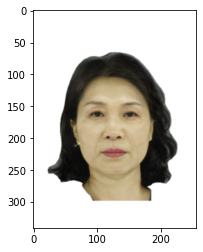

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 256

# 불러온 이미지가 Torch 객체로 변환될 수 있도록 하기
transform = []
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

img_path = "./9652.png"
image = Image.open(img_path)
# Torch의 첫 번째 차원은 배치(batch) 크기
image = transform(image).unsqueeze(0).to(device)

# 원본 이미지 출력
plt.imshow(solver.denorm(image.data.cpu()).squeeze(0).permute(1, 2, 0)) # 너비, 높이, 채널

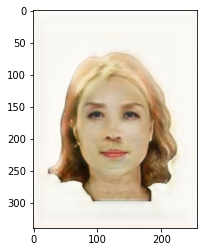

In [21]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[0, 1, 0, 1, 1]] # Blond_Hair, Male, Young
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))

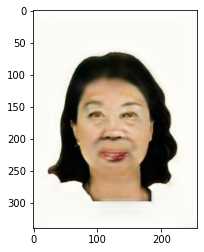

In [22]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[1, 0, 0, 1, 0]] # Black_Hair, Male
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))

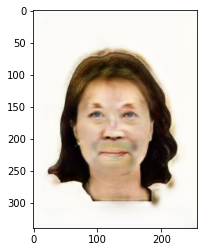

In [28]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[0, 0, 1, 1, 0]] # Brown_Hair, Male
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))